In [59]:
import re
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import seaborn as sns ; sns.set_context('talk') ; sns.set_palette('colorblind')
from pathlib import Path
from glob import glob
from tqdm import tqdm ; tqdm.pandas()
from rdkit.Chem import AllChem as Chem, Draw, rdBase
from rdkit.Chem.Draw import rdDepictor, rdMolDraw2D
rdDepictor.SetPreferCoordGen(True)
rdBase.DisableLog("rdApp.*")

from molscore.scoring_functions import PIDGIN
from moleval.utils import BM_scaffold, butina_picker
from moleval.metrics.metrics import SNNMetric

# Re-calculate SA score
from rdkit.Contrib.SA_Score import sascorer
def SAScore(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return sascorer.calculateScore(mol)
    else:
        return 0.0

In [2]:
# Note that SynFlowNet doesn't pass invalid or duplicate molecules to MolScore
# These can be inferred by filling each batch with dummy data for the duplicates / invalids that aren't provided
def fill_missing_dummy(df):
    batch_size = 64
    new_rows = []
    for step in df.step.unique():
        # Sample last row
        row = df.loc[df.step == step, :].iloc[-1]
        # Number to add
        for i in range(row.batch_idx+1, 64):
            n_row = row.copy()
            n_row.batch_idx = i
            n_row.unique = False
            new_rows.append(n_row)
    filler_df = pd.DataFrame(new_rows)
    new_df = pd.concat([df, filler_df]).sort_values(['step', 'batch_idx'])
    new_df.reset_index(inplace=True, drop=True)
    return new_df

# Optimizing JNK3 affinity with Boltz-2

In [22]:
# Load ACEGEN results
ATPc = pd.DataFrame()
for seed, fpath in enumerate(glob("data/ACEGEN_JNK3/run*.csv")):
    df = pd.read_csv(fpath, index_col=0).assign(seed=str(seed)).reset_index(names='idx')
    ATPc = pd.concat([ATPc, df], ignore_index=True)
# Add consistent step batch size of 100
ATPc['step100'] = ATPc.idx.apply(lambda x: x// 100)
# Recalculate SAScore
ATPc['desc_SAscore'] = ATPc.smiles.progress_apply(SAScore)

# Pool the top-100 from each seed subset
ATPc.sort_values(by=['seed', 'Boltz_affinity_pred_value'], ascending=(True, True), inplace=True)
ATPc_top100 = pd.DataFrame()
for seed in ATPc.seed.unique():
    ATPc_top100 = pd.concat([ATPc_top100, ATPc.loc[ATPc.seed == seed, :].iloc[:100]])
# Drop potential duplicates across seeds
ATPc_top100.drop_duplicates(subset='smiles', inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50062/50062 [03:01<00:00, 276.42it/s]


In [7]:
# Load SynFlowNet results
input_dirs = [
    'data/SFN_JNK3/SynFlowNet_42_JNK3_ATP_2025_07_06',
    'data/SFN_JNK3/SynFlowNet_43_JNK3_ATP_2025_07_08',
    'data/SFN_JNK3/SynFlowNet_44_JNK3_ATP_2025_07_09',
    'data/SFN_JNK3/SynFlowNet_45_JNK3_ATP_2025_07_11',
    'data/SFN_JNK3/SynFlowNet_46_JNK3_ATP_2025_07_13',
]
SFN = pd.DataFrame()
for seed, dir in enumerate(input_dirs):
    df = fill_missing_dummy(pd.read_csv(Path(dir) / 'scores.csv', index_col=0).assign(seed=str(seed))).reset_index(names='idx')
    SFN = pd.concat([SFN, df], ignore_index=True)
# Add consistent step batch size of 100
SFN['step100'] = SFN.idx.apply(lambda x: x // 100)
# Recalculate SAScore
SFN['desc_SAscore'] = SFN.smiles.progress_apply(SAScore)

# Pool the top-100 from each seed subset
SFN.sort_values(by=['seed', 'Boltz_affinity_pred_value'], ascending=(True, True), inplace=True)
SFN_top100 = pd.DataFrame()
for seed in SFN.seed.unique():
    SFN_top100 = pd.concat([SFN_top100, SFN.loc[(SFN.unique == True) & (SFN.seed == seed), :].iloc[:100]])
# Drop potential duplicates across seeds
SFN_top100.drop_duplicates(subset='smiles', inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47936/47936 [02:25<00:00, 330.26it/s]


In [5]:
# Load known JNK3 actives
JNK3_ATPc = pd.read_csv('data/JNK3/ATPc_scores.csv', index_col=0).reset_index(names='idx')
# Recalculate SAScore
JNK3_ATPc['desc_SAscore'] = JNK3_ATPc.smiles.progress_apply(SAScore)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 810/810 [00:03<00:00, 234.31it/s]


,idx,model,task,step,batch_idx,absolute_time,smiles,valid,valid_score,unique,...,norm_Boltz_affinity_pred_value,raw_Boltz_affinity_probability_binary,raw_desc_QED,amean,filter,passes_diversity_filter,filtered_amean,score_time,diversity_filter,diversity_filter_params
0,0,JNK3_actives,JNK3_test,1,0,13.604584,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,True,1,True,...,0.444993,0.751459,0.525196,0.573883,1.0,False,0.562405,41834.208345,ScaffoldSimilarityECFP,NaN
1,1,JNK3_actives,JNK3_test,1,1,13.604584,Cc1ccc(-n2nc(C(C)(C)C)cc2NC(=O)Nc2ccc(OCCN3CCO...,True,1,True,...,0.726643,0.905754,0.308784,0.647060,1.0,False,0.634119,41834.208345,ScaffoldSimilarityECFP,NaN
2,2,JNK3_actives,JNK3_test,1,2,13.604584,COc1cc2c(cc1Cl)C(c1cccc(Cl)c1F)=NCC2,True,1,True,...,0.080137,0.180474,0.794953,0.351854,1.0,True,0.351854,41834.208345,ScaffoldSimilarityECFP,NaN
3,3,JNK3_actives,JNK3_test,1,3,13.604584,c1ccc(-c2noc(CN3CCCCC3)c2-c2ccnc(NC3CCCCC3)n2)cc1,True,1,True,...,0.673429,0.882995,0.568791,0.708405,1.0,False,0.694237,41834.208345,ScaffoldSimilarityECFP,NaN
4,4,JNK3_actives,JNK3_test,1,4,13.604584,COc1cc2c(cc1Cl)C(c1cccc(Br)c1)=NCC2,True,1,True,...,0.083522,0.174346,0.780970,0.346279,1.0,True,0.346279,41834.208345,ScaffoldSimilarityECFP,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,805,JNK3_actives,JNK3_test,1,805,13.604584,Cc1ncn(-c2ccc(Nc3nccc(-c4cccc(N5CCOCC5)c4)n3)c...,True,1,True,...,0.533506,0.639594,0.535195,0.569432,1.0,False,0.546654,41834.208345,ScaffoldSimilarityECFP,NaN
806,806,JNK3_actives,JNK3_test,1,806,13.604584,CS(=O)(=O)Nc1ccc(-c2ccnc(Nc3ccc(S(N)(=O)=O)cc3...,True,1,True,...,0.440419,0.668635,0.553281,0.554112,1.0,False,0.531947,41834.208345,ScaffoldSimilarityECFP,NaN
807,807,JNK3_actives,JNK3_test,1,807,13.604584,Fc1cc(-c2cc[nH]/c(=N/c3ccc(-n4cnc(N5CCOCC5)n4)...,True,1,True,...,0.496177,0.625056,0.448298,0.523177,1.0,False,0.512714,41834.208345,ScaffoldSimilarityECFP,NaN
808,808,JNK3_actives,JNK3_test,1,808,13.604584,C[C@]12O[C@H](C[C@]1(O)CO)n1c3ccccc3c3c4c(c5c6...,True,1,True,...,0.387328,0.664538,0.373216,0.475027,1.0,True,0.475027,41834.208345,ScaffoldSimilarityECFP,NaN


#### Plot optimization curves

/shared/morgan/miniforge3/envs/molscore/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/shared/morgan/miniforge3/envs/molscore/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/shared/morgan/miniforge3/envs/molscore/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/shared/morgan/miniforge3/envs/molscore/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

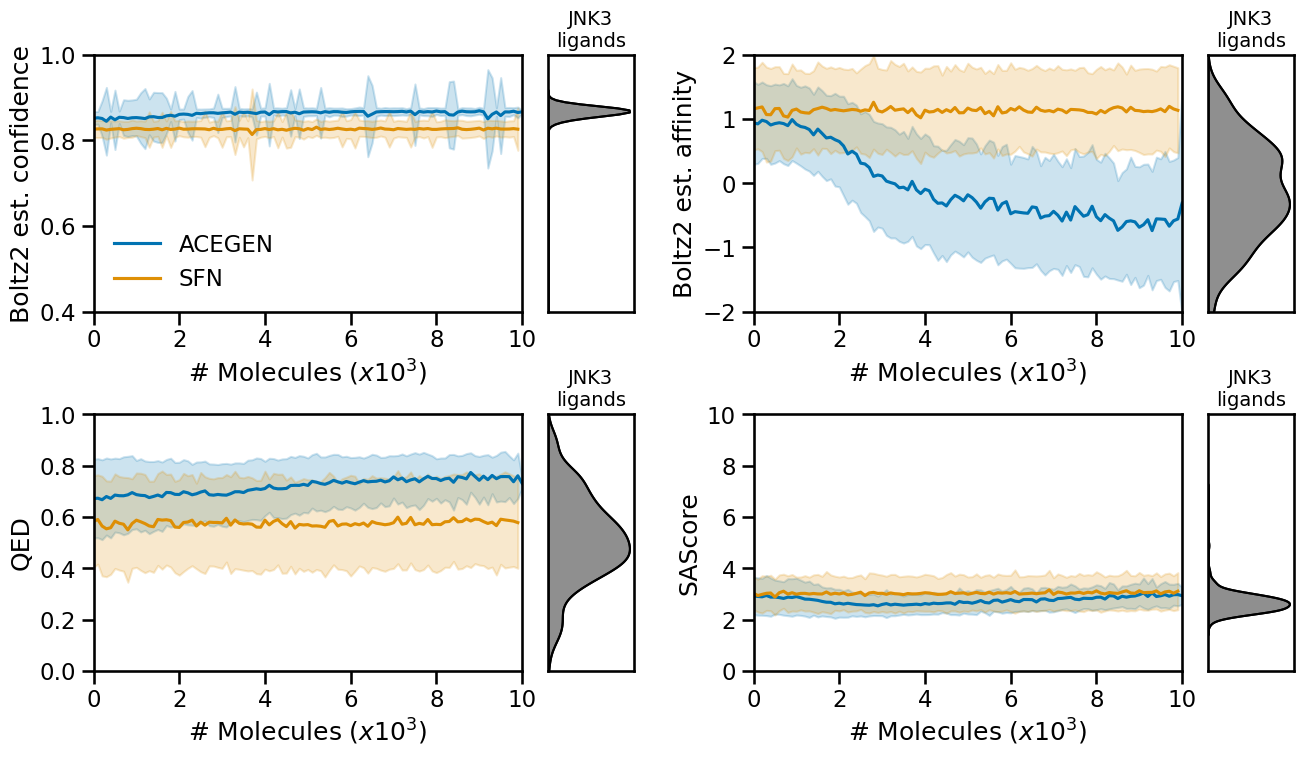

In [40]:
# ---- Setup Nested Gridspec
fig = plt.figure(figsize=(12, 8))
col1 = GridSpec(2, 2, figure=fig, width_ratios=[5, 1], left=0, right=0.45, wspace=0.1, hspace=0.4)
ax1 = fig.add_subplot(col1[0, 0])
ax1a = fig.add_subplot(col1[0, 1])
ax3 = fig.add_subplot(col1[1, 0])
ax3a = fig.add_subplot(col1[1, 1])

col2 = GridSpec(2, 2, figure=fig, width_ratios=[5, 1], left=0.55, right=1.0, wspace=0.1, hspace=0.4)
ax2 = fig.add_subplot(col2[0, 0])
ax2a = fig.add_subplot(col2[0, 1])
ax4 = fig.add_subplot(col2[1, 0])
ax4a = fig.add_subplot(col2[1, 1])

# --- Now plot
df1 = ATPc.loc[(ATPc.valid == True) & (ATPc.unique == True)]
df2 = SFN.loc[(SFN.valid == True) & (SFN.unique == True)]

for df, label in zip(
    [df1, df2],
    ['ACEGEN', 'SFN']
):

    # ---- Plot conf
    sns.lineplot(
        data=df.loc[df.idx <= 10000],
        x='step100',
        y='Boltz_confidence_score',
        #hue='seed',
        errorbar='sd',
        legend=True,
        label=label,
        ax=ax1
    )
    ax1.set_ylabel('Boltz2 est. confidence')
    ax1.set_ylim(0.4, 1)
    sns.kdeplot(
        data=JNK3_ATPc,
        y='Boltz_confidence_score',
        fill=True,
        color='k',
        ax=ax1a
    )
    ax1a.set_ylim(0.4, 1)
    
    # ---- Plot affinity
    sns.lineplot(
        data=df.loc[df.idx <= 10000],
        x='step100',
        y='Boltz_affinity_pred_value',
        #hue='seed',
        errorbar='sd',
        legend=False,
        label=label,
        ax=ax2
    )
    ax2.set_ylabel('Boltz2 est. affinity')
    ax2.set_ylim(-2, 2)
    sns.kdeplot(
        data=JNK3_ATPc,
        y='Boltz_affinity_pred_value',
        fill=True,
        color='k',
        ax=ax2a
    )
    ax2a.set_ylim(-2, 2)
    
    # ---- Plot QED
    sns.lineplot(
        data=df.loc[df.idx <= 10000],
        x='step100',
        y='desc_QED',
        #hue='seed',
        errorbar='sd',
        legend=False,
        label=label,
        ax=ax3
    )
    ax3.set_ylabel('QED')
    ax3.set_ylim(0, 1)
    sns.kdeplot(
        data=JNK3_ATPc,
        y='desc_QED',
        fill=True,
        color='k',
        ax=ax3a
    )
    ax3a.set_ylim(0, 1)
    
    # ---- Plot SAScore
    sns.lineplot(
        data=df.loc[df.idx <= 10000],
        x='step100',
        y='desc_SAscore',
        #hue='seed',
        errorbar='sd',
        legend=False,
        label=label,
        ax=ax4,
        
    )
    ax4.set_ylabel('SAScore')
    ax4.set_ylim(0, 10)
    sns.kdeplot(
        data=JNK3_ATPc,
        y='desc_SAscore',
        fill=True,
        color='k',
        ax=ax4a
    )
    ax4a.set_ylim(0, 10)

for ax in [ax1, ax2, ax3, ax4]:
    # Remap x axis
    ax.set_xticks(ticks=np.linspace(0, 100, 6), labels=[str(l) for l in np.linspace(0, 10, 6, dtype='int')])
    ax.set_xlim(0, 100)
    ax.set_xlabel('# Molecules ($x10^3$)')

for ax in [ax1a, ax2a, ax3a, ax4a]:
    ax.set_ylabel("")
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_title("JNK3\nligands", fontsize=14)

ax1.legend(frameon=False)
plt.savefig('figures/AGvsSFN_curves.png', dpi=300, bbox_inches='tight')

#### Plot similarity

In [12]:
# Prepare SNN Metric
snn_metric = SNNMetric() # Default ECFP4 w. 1024 bits
# Load JNK3 actives
JNK3_actives = pd.read_csv('data/JNK3/actives.csv')
# Filter pChEMBL >= 6
JNK3_actives = JNK3_actives.loc[JNK3_actives.pchembl_value >= 6]
# Calculate Bemis-Murcko Scaffolds
JNK3_smiles = JNK3_actives.canonical_smiles.tolist()
JNK3_scaffolds = [BM_scaffold(s) for s in JNK3_smiles]
# Calculate Scaffold SNN of top500
ATPc_top100['SNN_Sim'] = snn_metric(ref=JNK3_scaffolds, gen=[BM_scaffold(s) for s in ATPc_top100.smiles.tolist()])
SFN_top100['SNN_Sim'] = snn_metric(ref=JNK3_scaffolds, gen=[BM_scaffold(s) for s in SFN_top100.smiles.tolist()])

/shared/morgan/miniforge3/envs/molscore/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/shared/morgan/miniforge3/envs/molscore/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/shared/morgan/miniforge3/envs/molscore/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/shared/morgan/miniforge3/envs/molscore/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

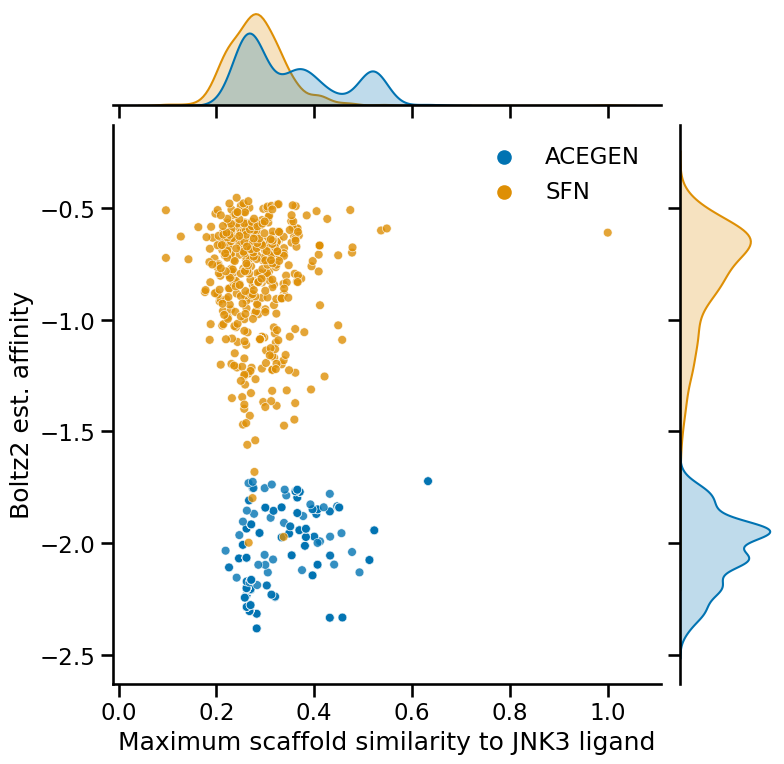

In [13]:
# Plot scaff
tdf = pd.concat([ATPc_top100.assign(run='ACEGEN'), SFN_top100.assign(run='SFN')])
sns.jointplot(
    data=tdf,
    x='SNN_Sim',
    y='Boltz_affinity_pred_value',
    hue='run',
    height=8,
    joint_kws={"s": 40, "alpha": 0.8}
)
plt.legend(title="", frameon=False)
plt.xlabel('Maximum scaffold similarity to JNK3 ligand')
plt.ylabel('Boltz2 est. affinity')
#plt.savefig('figures/AGvsSFN_scaffsim.png', dpi=300, bbox_inches='tight')

#### Plot selectivity

Plots generated by inserting text generated into [kinome mapper](http://www.kinhub.org/kinmap/)

Syntax: \
@ shape : size : fill color : stroke color : stroke width \
Example: \
@0:20:red:black:1.5

In [16]:
# Get list of UNIPROTS
kinome = PIDGIN.get_uniprot_groups()['2 - Kinase (430)']

# Get map to gene names
accession2name = {}
for acc in tqdm(kinome):
    response = requests.get(f"https://rest.uniprot.org/uniprotkb/search?query={acc}&fields=accession,gene_names")
    gene_name = response.json()['results'][0]['genes'][0]['geneName']['value']
    accession2name[acc] = gene_name

kinome_columns = [f"Kinome_{k}@10uM" for k in kinome]
def unmaxminnorm(x, max=100, min=0):
    return int(x*max - x*min + min)

In [17]:
# Data for known JNK3 ligands
JNK3_pidgin = pd.read_csv('data/JNK3/PIDGIN_KINOME_10uM_2025_07_07/scores.csv', index_col=0)
ratio = JNK3_pidgin.loc[:, JNK3_pidgin.columns.isin(kinome_columns)].sum() / len(JNK3_pidgin)
ratio.index = [accession2name[x.split("_")[1].split("@")[0]] for x in ratio.index] # Rename
ratio.sort_values(ascending=False, inplace=True) # Sort
# Re arrange to text
for x, c in zip([0.8, 0.6, 0.4, 0.2], ['firebrick', 'red', 'tomato', 'orange']):
    print(f"@O:{unmaxminnorm(x)}:{c}:black:1.5")
    for name in ratio[ratio > x].index:
        print(name)

@O:80:firebrick:black:1.5
@O:60:red:black:1.5
MAPK8
MAPK9
@O:40:tomato:black:1.5
MAPK8
MAPK9
MAP3K4
MAPK10
AURKC
MAPK12
@O:20:orange:black:1.5
MAPK8
MAPK9
MAP3K4
MAPK10
AURKC
MAPK12
NUAK2
LTK
MAPK14
MAPK13
FRK
TAOK1
ROS1
CDK2
CDK7
JAK3
FGR
PDGFRA
MAPK11
TYRO3
MAPK15
KDR
PRKD2
CDK1
CDK11B
ERBB4
GAK
SLK
MAP2K2
IRAK1
KIT
LCK
ANKK1
FYN
MUSK
ERBB3
MAP3K19
CSF1R
INSR
AURKB
DCLK1
MAP4K5
HIPK4
DYRK3
RET
ULK3
STK17A
ALK
FER
FLT3


In [21]:
# Data for ACEGEN results
ATPc_pidgin = pd.read_csv('data/ACEGEN_JNK3/PIDGIN_KINOME_10uM_2025_07_08/scores.csv', index_col=0)
ratio = ATPc_pidgin.loc[:, ATPc_pidgin.columns.isin(kinome_columns)].sum() / len(ATPc_pidgin)
ratio.index = [accession2name[x.split("_")[1].split("@")[0]] for x in ratio.index] # Rename
ratio.sort_values(ascending=False, inplace=True) # Sort
# Re arrange to text
for x, c in zip([0.8, 0.6, 0.4, 0.2], ['firebrick', 'red', 'tomato', 'orange']):
    print(f"@O:{unmaxminnorm(x)}:{c}:black:1.5")
    for name in ratio[ratio > x].index:
        print(name)

@O:80:firebrick:black:1.5
CDK7
CDK1
AURKC
@O:60:red:black:1.5
CDK7
CDK1
AURKC
CDK2
CDK4
MAP3K4
LRRK2
LTK
TYRO3
PLK1
IKBKE
CDK9
ZAP70
PKMYT1
FRK
@O:40:tomato:black:1.5
CDK7
CDK1
AURKC
CDK2
CDK4
MAP3K4
LRRK2
LTK
TYRO3
PLK1
IKBKE
CDK9
ZAP70
PKMYT1
FRK
EPHA2
GAK
FLT4
DCLK1
ALK
ROS1
TAOK1
CDK6
CLK2
JAK3
PDGFRA
AURKB
MAP3K19
SYK
PLK3
MARK3
CDK11A
AURKA
NUAK2
INSR
MAPK1
PAK1
LCK
BLK
AXL
IGF1R
SGK2
NTRK3
SGK1
ERBB3
CSF1R
HIPK2
ERBB4
@O:20:orange:black:1.5
CDK7
CDK1
AURKC
CDK2
CDK4
MAP3K4
LRRK2
LTK
TYRO3
PLK1
IKBKE
CDK9
ZAP70
PKMYT1
FRK
EPHA2
GAK
FLT4
DCLK1
ALK
ROS1
TAOK1
CDK6
CLK2
JAK3
PDGFRA
AURKB
MAP3K19
SYK
PLK3
MARK3
CDK11A
AURKA
NUAK2
INSR
MAPK1
PAK1
LCK
BLK
AXL
IGF1R
SGK2
NTRK3
SGK1
ERBB3
CSF1R
HIPK2
ERBB4
STK17A
KIT
CDK11B
DYRK3
CSNK1A1
MAPK12
MAP4K5
FLT3
DYRK1A
CCNK
PRKG2
CLK4
DYRK4
TBK1
HIPK4
IRAK1
PLK2
FGFR1
SMG1
PRKD2
ACVR1B
MAPK9
TSSK1B
STK3
CAMK2B
MAP2K2
CAMK2D
PDPK1
CHEK2
CDC42BPA
KDR
FGR
PIM3
MKNK2
PTK6
CDC7
BRSK1
DAPK3
NEK4
PRKX
MAP4K4
MINK1
MAPK8
FYN
ACVR1
TNK2
SRC
CDK19
RET
C

# Optimizing JNK3 allosteric affinity with Boltz-2

In [23]:
# Load ACEGEN non-ATP-competitive results
input_dirs = [
    'data/ACEGEN_JNK3-allo/acegen_AG_2025_06_27_104444/',
    'data/ACEGEN_JNK3-allo/acegen_AG_2025_06_29_043221/',
    'data/ACEGEN_JNK3-allo/acegen_AG_2025_06_30_210924/',
    'data/ACEGEN_JNK3-allo/acegen_AG_2025_07_02_163231/',
    'data/ACEGEN_JNK3-allo/acegen_AG_2025_07_04_101042/',
]
nATPc = pd.DataFrame()
for seed, dir in enumerate(input_dirs):
    df = pd.read_csv(Path(dir) / 'scores.csv', index_col=0).assign(seed=str(seed), input_dir=dir).reset_index(names='idx')
    nATPc = pd.concat([nATPc, df], ignore_index=True)
# Add consistent step batch size of 100
nATPc['step100'] = nATPc.idx.apply(lambda x: x // 100)
# Recalculate SAScore
nATPc['desc_SAscore'] = nATPc.smiles.progress_apply(SAScore)

# Pool the top-100 from each seed subset
nATPc.sort_values(by=['seed', 'Boltz_affinity_pred_value'], ascending=(True, True), inplace=True)
nATPc_top100 = pd.DataFrame()
for seed in nATPc.seed.unique():
    nATPc_top100 = pd.concat([nATPc_top100, nATPc.loc[(nATPc.unique == True) & (nATPc.seed == seed), :].iloc[:100]])
# Drop potential duplicates across seeds
nATPc_top100.drop_duplicates(subset='smiles', inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50050/50050 [03:05<00:00, 270.11it/s]


,idx,model,task,step,batch_idx,absolute_time,smiles,valid,valid_score,unique,...,amean,filter,passes_diversity_filter,filtered_amean,score_time,diversity_filter,diversity_filter_params,seed,input_dir,step100
0,0,AG,JNK3_ATP,1,0,18.397175,CCCCCSc1nc2nc(C)cc(C)n2n1,True,1,True,...,0.454557,1.0,True,0.454557,645.890451,ScaffoldSimilarityECFP,NaN,0,data/ACEGEN_JNK3-allo/acegen_AG_2025_06_27_104...,0
1,1,AG,JNK3_ATP,1,1,18.397175,CCCCN1CCN(c2ccccc2OC)CC1,True,1,True,...,0.558610,1.0,False,0.547437,645.890451,ScaffoldSimilarityECFP,NaN,0,data/ACEGEN_JNK3-allo/acegen_AG_2025_06_27_104...,0
2,2,AG,JNK3_ATP,1,2,18.397175,N#Cc1c(SCCc2ccc(C=CC(=O)O)cc2)sc2c1CCCC2,True,1,True,...,0.636969,1.0,False,0.624229,645.890451,ScaffoldSimilarityECFP,NaN,0,data/ACEGEN_JNK3-allo/acegen_AG_2025_06_27_104...,0
3,3,AG,JNK3_ATP,1,3,18.397175,Cc1ccc2c(c1)C(O)(c1ccccc1)CN2C(=O)C1CCC(C(=O)O)N1,True,1,True,...,0.537883,1.0,False,0.527125,645.890451,ScaffoldSimilarityECFP,NaN,0,data/ACEGEN_JNK3-allo/acegen_AG_2025_06_27_104...,0
4,4,AG,JNK3_ATP,1,4,18.397175,N#Cc1cnn(C2CC3COCC2N3)c1NC(=O)c1cccc(Cl)c1,True,1,True,...,0.513591,1.0,False,0.503320,645.890451,ScaffoldSimilarityECFP,NaN,0,data/ACEGEN_JNK3-allo/acegen_AG_2025_06_27_104...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50045,10008,AG,JNK3_ATP,322,25,146832.810799,Cc1c(N=C(N)C2=C(O)NC(=O)C2)ccc(Cl)c1Cl,True,1,True,...,0.436111,1.0,True,0.436111,254.341887,ScaffoldSimilarityECFP,NaN,4,data/ACEGEN_JNK3-allo/acegen_AG_2025_07_04_101...,100
50046,10009,AG,JNK3_ATP,322,26,146832.810799,CN1CCN(C2CCC(Nc3cc(Cl)c4ccncc4n3)CC2)CC1,True,1,False,...,0.843527,1.0,False,0.000000,254.341887,ScaffoldSimilarityECFP,NaN,4,data/ACEGEN_JNK3-allo/acegen_AG_2025_07_04_101...,100
50047,10010,AG,JNK3_ATP,322,27,146832.810799,Brc1cc(NC2CCC(N3CCOCC3)CC2)nc2cnccc12,True,1,True,...,0.859580,1.0,False,0.842388,254.341887,ScaffoldSimilarityECFP,NaN,4,data/ACEGEN_JNK3-allo/acegen_AG_2025_07_04_101...,100
50048,10011,AG,JNK3_ATP,322,28,146832.810799,CCn1ccc2c(Br)cc(NC3CCCN(C)C3)nc21,True,1,False,...,0.882370,1.0,False,0.000000,254.341887,ScaffoldSimilarityECFP,NaN,4,data/ACEGEN_JNK3-allo/acegen_AG_2025_07_04_101...,100


In [30]:
# Load JNK3 nATPc
JNK3_nATPc = pd.read_csv('data/JNK3/nATPc_scores.csv', index_col=0).reset_index(names='idx')
JNK3_nATPc['desc_SAscore'] = JNK3_nATPc.smiles.progress_apply(SAScore)
JNK3_Boltz = pd.concat([JNK3_ATPc.assign(run='ATP-site'), JNK3_nATPc.assign(run='Allosteric')])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 810/810 [00:03<00:00, 229.15it/s]


#### Plot optimization

In [ ]:
# ---- Setup Nested Gridspec
fig = plt.figure(figsize=(12, 8))
col1 = GridSpec(2, 2, figure=fig, width_ratios=[5, 1], left=0, right=0.45, wspace=0.1, hspace=0.4)
ax1 = fig.add_subplot(col1[0, 0])
ax1a = fig.add_subplot(col1[0, 1])
ax3 = fig.add_subplot(col1[1, 0])
ax3a = fig.add_subplot(col1[1, 1])

col2 = GridSpec(2, 2, figure=fig, width_ratios=[5, 1], left=0.55, right=1.0, wspace=0.1, hspace=0.4)
ax2 = fig.add_subplot(col2[0, 0])
ax2a = fig.add_subplot(col2[0, 1])
ax4 = fig.add_subplot(col2[1, 0])
ax4a = fig.add_subplot(col2[1, 1])

# --- Now plot
df1 = ATPc.loc[(ATPc.valid == True) & (ATPc.unique == True)]
df2 = nATPc.loc[(nATPc.valid == True) & (nATPc.unique == True)]

for df, label in zip(
    [df1, df2],
    ['ATP site', 'Allosteric']
):

    # ---- Plot conf
    sns.lineplot(
        data=df.loc[df.idx <= 10000],
        x='step100',
        y='Boltz_confidence_score',
        #hue='seed',
        errorbar='sd',
        legend=True,
        label=label,
        ax=ax1
    )
    ax1.set_ylabel('Boltz2 est. confidence')
    ax1.set_ylim(0.4, 1)
    sns.kdeplot(
        data=JNK3_Boltz,
        y='Boltz_confidence_score',
        hue='run',
        fill=True,
        legend=False,
        ax=ax1a
    )
    ax1a.set_ylim(0.4, 1)
    
    # ---- Plot affinity
    sns.lineplot(
        data=df.loc[df.idx <= 10000],
        x='step100',
        y='Boltz_affinity_pred_value',
        #hue='seed',
        errorbar='sd',
        legend=False,
        label=label,
        ax=ax2
    )
    ax2.set_ylabel('Boltz2 est. affinity')
    ax2.set_ylim(-2, 2)
    sns.kdeplot(
        data=JNK3_Boltz,
        y='Boltz_affinity_pred_value',
        hue='run',
        fill=True,
        legend=False,
        ax=ax2a
    )
    ax2a.set_ylim(-2, 2)
    
    # ---- Plot QED
    sns.lineplot(
        data=df.loc[df.idx <= 10000],
        x='step100',
        y='desc_QED',
        #hue='seed',
        errorbar='sd',
        legend=False,
        label=label,
        ax=ax3
    )
    ax3.set_ylabel('QED')
    ax3.set_ylim(0, 1)
    sns.kdeplot(
        data=JNK3_Boltz,
        y='desc_QED',
        fill=True,
        color='k',
        ax=ax3a
    )
    ax3a.set_ylim(0, 1)
    
    # ---- Plot SAScore
    sns.lineplot(
        data=df.loc[df.idx <= 10000],
        x='step100',
        y='desc_SAscore',
        #hue='seed',
        errorbar='sd',
        legend=False,
        label=label,
        ax=ax4,
        
    )
    ax4.set_ylabel('SAScore')
    ax4.set_ylim(0, 10)
    sns.kdeplot(
        data=JNK3_Boltz,
        y='desc_SAscore',
        fill=True,
        color='k',
        ax=ax4a
    )
    ax4a.set_ylim(0, 10)

for ax in [ax1, ax2, ax3, ax4]:
    # Remap x axis
    ax.set_xticks(ticks=np.linspace(0, 100, 6), labels=[str(l) for l in np.linspace(0, 10, 6, dtype='int')])
    ax.set_xlim(0, 100)
    ax.set_xlabel('# Molecules ($x10^3$)')

for ax in [ax1a, ax2a, ax3a, ax4a]:
    ax.set_ylabel("")
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_title("JNK3\nligands", fontsize=14)
    ax.legend

ax1.legend(frameon=False)
plt.savefig('figures/allo_curves.png', dpi=600, bbox_inches='tight')

#### Plot similarity

In [33]:
# Prepare SNN Metric
snn_metric = SNNMetric() # Default ECFP4 w. 1024 bits
# Load JNK3 actives
JNK3_actives = pd.read_csv('data/JNK3/actives.csv')
# Filter pChEMBL >= 6
JNK3_actives = JNK3_actives.loc[JNK3_actives.pchembl_value >= 6]
# Calculate Bemis-Murcko Scaffolds
JNK3_smiles = JNK3_actives.canonical_smiles.tolist()
JNK3_scaffolds = [BM_scaffold(s) for s in JNK3_smiles]
# Calculate Scaffold SNN of top500
ATPc_top100['SNN_Sim'] = snn_metric(ref=JNK3_scaffolds, gen=[BM_scaffold(s) for s in ATPc_top100.smiles.tolist()])
nATPc_top100['SNN_Sim'] = snn_metric(ref=JNK3_scaffolds, gen=[BM_scaffold(s) for s in nATPc_top100.smiles.tolist()])

/shared/morgan/miniforge3/envs/molscore/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/shared/morgan/miniforge3/envs/molscore/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/shared/morgan/miniforge3/envs/molscore/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/shared/morgan/miniforge3/envs/molscore/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

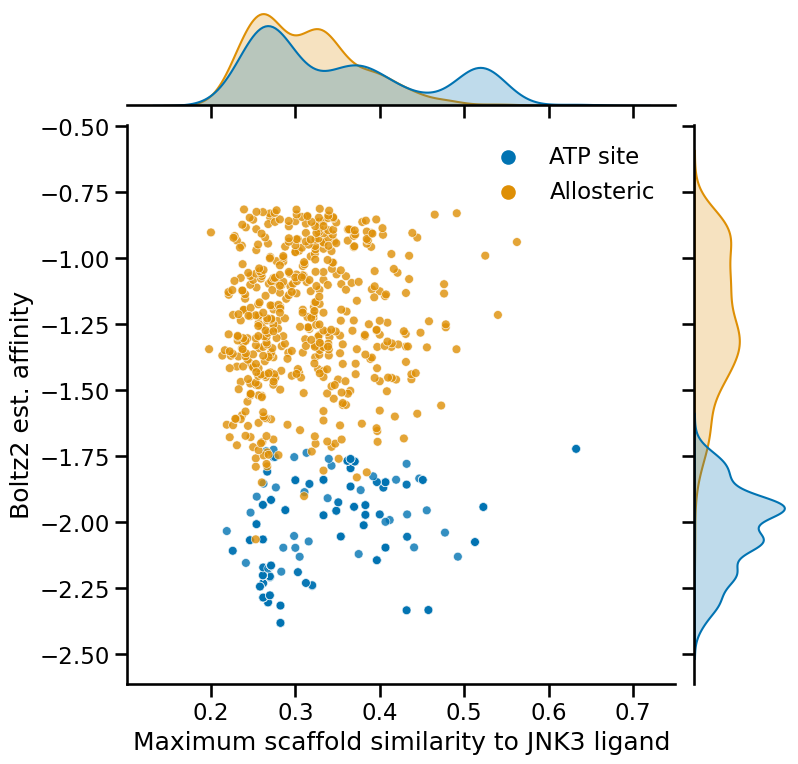

In [35]:
# Plot scaff
tdf = pd.concat([ATPc_top100.assign(run='ATP site'), nATPc_top100.assign(run='Allosteric')])
sns.jointplot(
    data=tdf,
    x='SNN_Sim',
    y='Boltz_affinity_pred_value',
    hue='run',
    height=8,
    joint_kws={"s": 40, "alpha": 0.8}
)
plt.legend(title="", frameon=False)
plt.xlabel('Maximum scaffold similarity to JNK3 ligand')
plt.ylabel('Boltz2 est. affinity')
#plt.savefig('figures/allo_scaffsim.png', dpi=300, bbox_inches='tight')

#### 3D Analysis
... is not included for GitHub storage limitation reasons. \
However! A pymol session file is available with the structures shown in the figure.

#### Selectivity
Need to load the kinome map from the first section

In [36]:
nATPc_pidgin = pd.read_csv('data/ACEGEN_JNK3-allo/PIDGIN_KINOME_10uM_2025_07_08/scores.csv', index_col=0)
ratio = nATPc_pidgin.loc[:, nATPc_pidgin.columns.isin(kinome_columns)].sum() / len(nATPc_pidgin)
ratio.index = [accession2name[x.split("_")[1].split("@")[0]] for x in ratio.index] # Rename
ratio.sort_values(ascending=False, inplace=True) # Sort
# Re arrange to text
for x, c in zip([0.8, 0.6, 0.4, 0.2], ['firebrick', 'red', 'tomato', 'orange']):
    print(f"@O:{unmaxminnorm(x)}:{c}:black:1.5")
    for name in ratio[ratio > x].index:
        print(name)

@O:80:firebrick:black:1.5
@O:60:red:black:1.5
@O:40:tomato:black:1.5
@O:20:orange:black:1.5
MAP3K4
NUAK2
ULK3
RIPK2


# Absolute binding free energy

#### Selection

Here we sample up to 10 (diverse if possible) molecules +/- 0.25 from each major bin i.e.,
- Boltz-2 affinity of -2 is pKi=8
- Boltz-2 affinity of -1 is pKi=7
- Boltz-2 affinity of 0 is pKi=6
- Boltz-2 affinity of 1 is pKi=5

To try to avoid molecular weight and polarity/lipophilicity biases, we also sample from,
- 25 <= Heavy Atoms <= 35
- 2 <= LogP <=4

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 57587.70it/s]

list index out of range
Target: -2, clustered: False


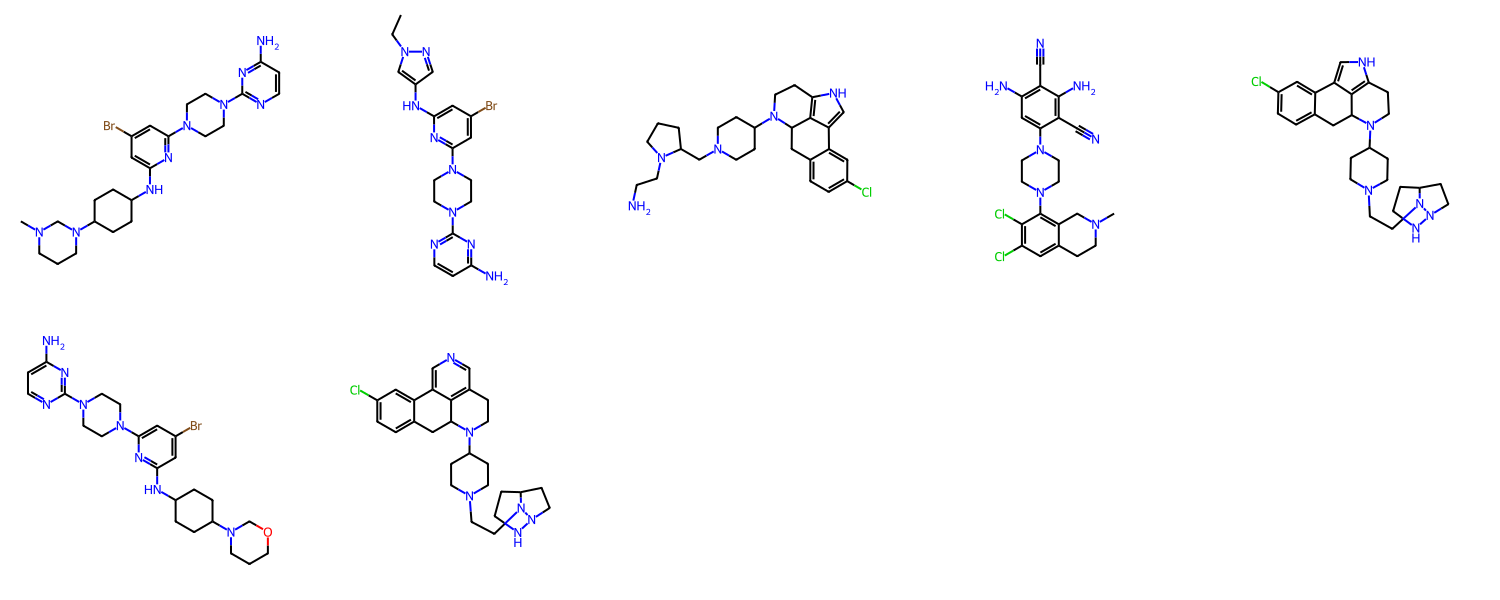

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 651/651 [00:00<00:00, 12866.51it/s]

Target: -1, clustered: True


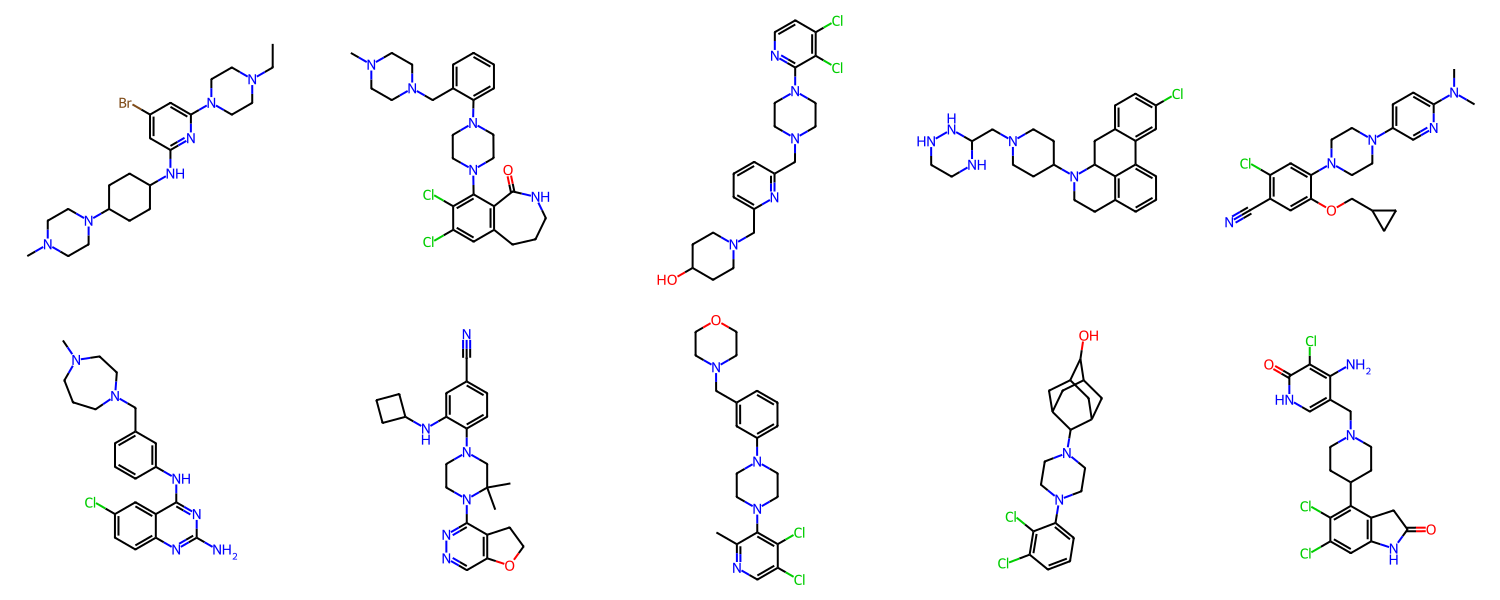

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1896/1896 [00:00<00:00, 4731.51it/s]


Target: 0, clustered: True


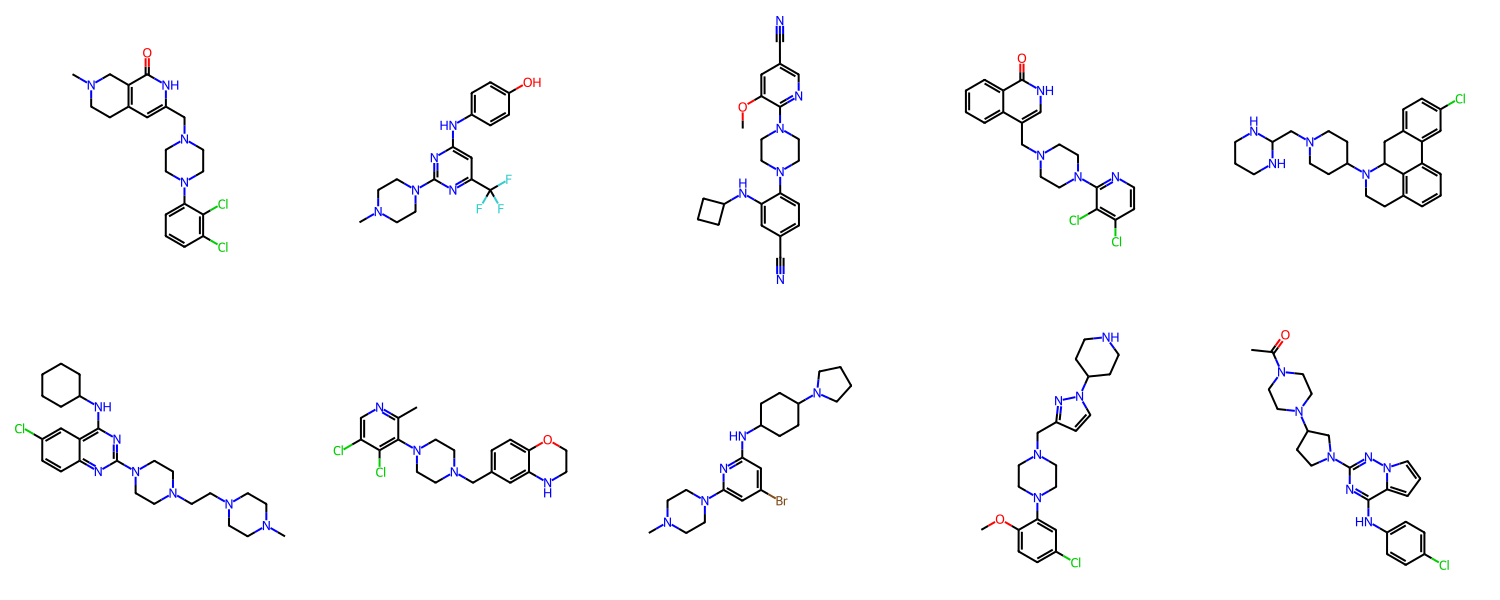

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1841/1841 [00:00<00:00, 4961.59it/s]


Target: 1, clustered: True


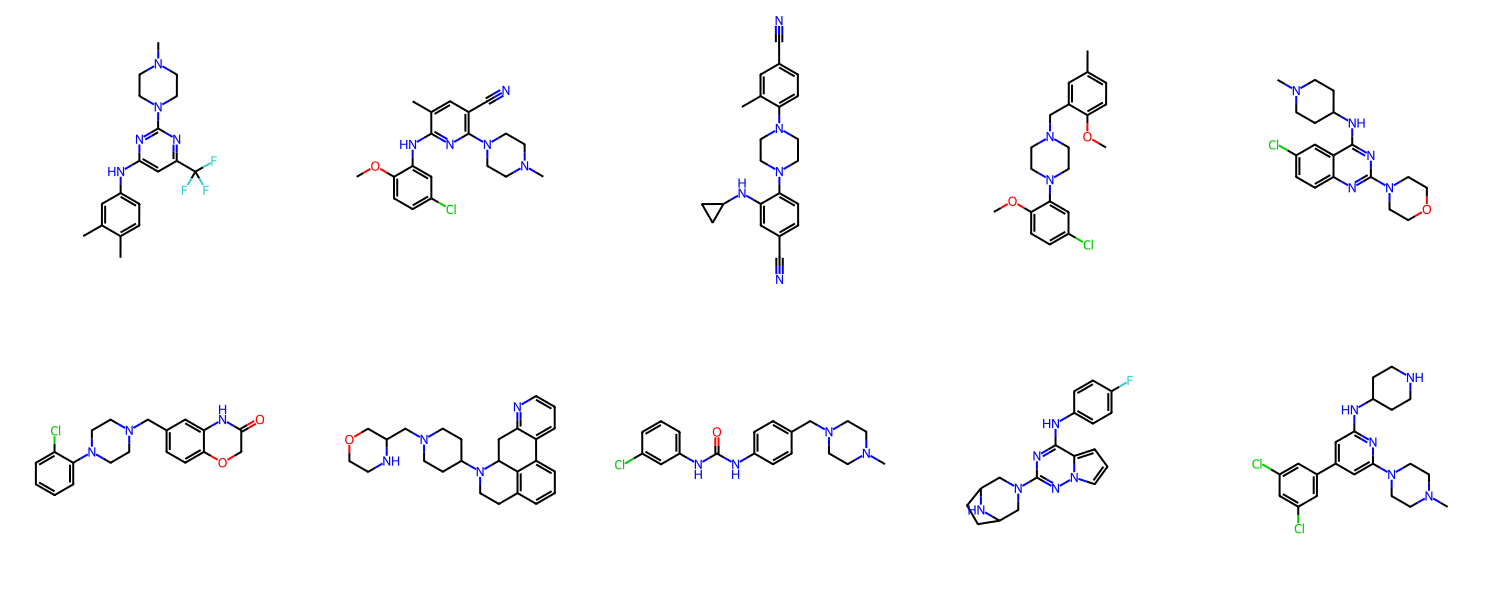

In [60]:
# ---- Sample molecules to run AFEP
# Valid and unique
tdf = nATPc.loc[nATPc.valid & nATPc.unique]
# Remove duplicates across runs
tdf = tdf.drop_duplicates(subset=['smiles'])
# Sort
tdf = tdf.sort_values('Boltz_affinity_pred_value')

# Lets go for target_value +- 0.25
for tv, label in zip([-2, -1, 0, 1], ["p8", "p7", "p6", "p5"]):
    ttdf = tdf.loc[tdf.Boltz_affinity_pred_value.between(tv-0.25, tv+0.25) & tdf.desc_HeavyAtomCount.between(25, 35) & tdf.desc_CLogP.between(2, 4)]
    N = min(10, len(ttdf))
    try:
        # Cluster and pick centroids
        mols, sizes, ids, cs = butina_picker(
                dataset=ttdf.smiles.tolist(),
                n=N,
                threshold=0.65,
                reordering=True,
                return_cs=True
        )
        clustered=True
    except Exception as e:
        # Otherwise just pick top-n
        print(e)
        mols = [Chem.MolFromSmiles(ttdf.smiles.iloc[i]) for i in range(N)]
        clustered=False
    
    print(f"Target: {tv}, clustered: {clustered}")
    # Draw
    img = Draw.MolsToGridImage(
        mols=mols,
        #legends=[str(s) for s in sizes],
        molsPerRow=5,
        subImgSize=(300,300)
    )
    display(img)

#### Analyse

In [45]:
# Load results 1
afep_results = pd.read_csv('data/ACEGEN_JNK3-allo/AFEP/AFEP_results_1.csv')
afep_results['err'] = afep_results['Pred. Binding (pKi)'].str.split(" ", expand=True)[2].astype(float)
afep_results['pKi'] = afep_results['pKi'].replace(0.0, np.NaN)
# Load results 2
afep_results2 = pd.read_csv('data/ACEGEN_JNK3-allo/AFEP/AFEP_results_2.csv')
# Create the same columns as first results
afep_results2['bin'] = afep_results2.bin.apply(lambda x: f"p{x}")
afep_results2['Ligand'] = afep_results2.Ligand.apply(lambda x: f"p{re.sub('_new', '', x)}")
# Merge AFEP results
afep_results = pd.concat([afep_results, afep_results2], axis=0, ignore_index=True).filter(items=['Ligand', 'pKi', 'bin']).dropna(subset='pKi')
afep_results = afep_results.loc[afep_results.pKi >= 2.5] # NOTE: Drop outliers
afep_results

,Ligand,pKi,bin
0,p8_sel4_seed1_288_27_model_0_prep_split_ligand2,7.300000,p8
1,p8_sel3_seed0_210_26_model_0_prep_split_ligand2,7.100000,p8
2,p8_sel2_seed1_290_22_model_0_prep_split_ligand2,6.800000,p8
3,p8_sel1_seed4_225_19_model_0_prep_split_ligand2,8.600000,p8
4,p7_sel3_seed1_272_8_model_0_prep_split_ligand2,8.600000,p7
6,p7_sel2_seed2_258_27_model_0_prep_split_ligand2,5.600000,p7
8,p6_sel4_seed1_209_6_model_0_prep_split_ligand2,5.400000,p6
9,p6_sel3_seed0_157_28_model_0_prep_split_ligand2,6.700000,p6
10,p6_sel2_seed3_182_13_model_0_prep_split_ligand2,7.200000,p6
11,p6_sel1_seed3_186_24_model_0_prep_split_ligand2,6.200000,p6


/shared/morgan/miniforge3/envs/molscore/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/shared/morgan/miniforge3/envs/molscore/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/shared/morgan/miniforge3/envs/molscore/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/shared/morgan/miniforge3/envs/molscore/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

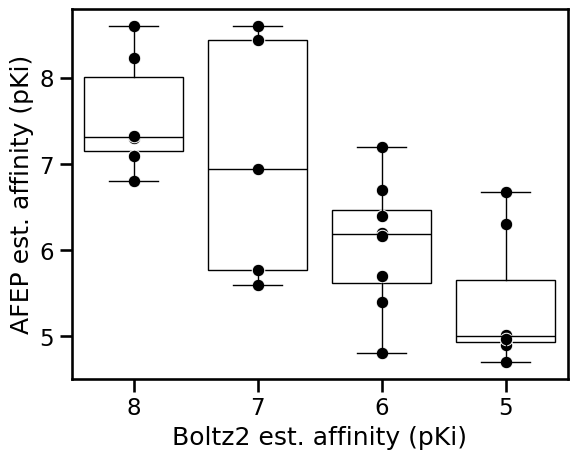

In [51]:
# Plot binned
sns.scatterplot(
    data=afep_results,
    x='bin',
    y='pKi',
    #size=0.1,
    color='k'
)
sns.boxplot(
    data=afep_results,
    x='bin',
    y='pKi',
    color='k',
    linewidth=1,
    showcaps=True,
    boxprops={'facecolor':'None'}
)
plt.ylabel('AFEP est. affinity (pKi)')
plt.xlabel('Boltz2 est. affinity (pKi)')
plt.xticks(ticks=list(range(4)), labels=['8', '7', '6', '5']);
plt.savefig('figures/allo_AFEP_binned.png', dpi=300, bbox_inches='tight')

In [52]:
# ANOVA
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
model = smf.ols('pKi ~ C(bin)', data=afep_results).fit()
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA
print(anova_table)
# Tukey HSD
tukey = pairwise_tukeyhsd(endog=afep_results['pKi'], groups=afep_results['bin'], alpha=0.05)
print(tukey)

             sum_sq    df         F    PR(>F)
C(bin)    18.662597   3.0  7.528882  0.001208
Residual  18.177870  22.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    p5     p6   0.7045 0.4559 -0.6019 2.0108  False
    p5     p7   1.7051 0.0198  0.2271 3.1831   True
    p5     p8   2.1934 0.0014  0.7891 3.5977   True
    p6     p7   1.0006 0.2445 -0.4383 2.4396  False
    p6     p8   1.4889 0.0289  0.1258 2.8521   True
    p7     p8   0.4883 0.8115 -1.0401 2.0168  False
---------------------------------------------------


In [54]:
# Merge with actual Boltz2 est. affinity for correlation analysis
boltz2_actual = []
smiles = []
for i, row in afep_results.iterrows():
    _, _, seed, step, bidx = row.Ligand.split("_")[:5]
    seed = seed.strip('seed')
    step = int(step)
    bidx = int(bidx)
    row = nATPc.loc[(nATPc.seed==seed) & (nATPc.step==step) & (nATPc.batch_idx==bidx)].iloc[0]#, 'Boltz_affinity_pred_value']
    boltz2_actual.append(row.Boltz_affinity_pred_value)
    smiles.append(row.smiles)
afep_results['smiles'] = smiles
afep_results['Boltz2_actual'] = abs(np.asarray(boltz2_actual) - 6)

/shared/morgan/miniforge3/envs/molscore/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/shared/morgan/miniforge3/envs/molscore/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


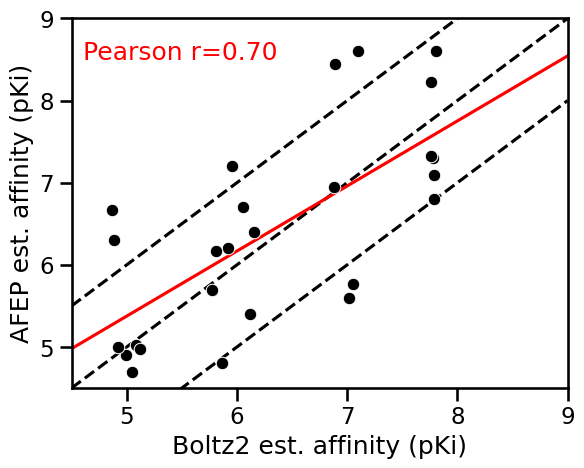

In [57]:
# Plot by correlation
from scipy.stats import pearsonr, linregress

# Pearson correlation
r, p_value = pearsonr(afep_results.Boltz2_actual.tolist(), afep_results.pKi.tolist())
lr = linregress(afep_results.Boltz2_actual.tolist(), afep_results.pKi.tolist())
def lrfunc(x):
    return (lr.slope * x) + lr.intercept

sns.scatterplot(
    data=afep_results,
    x='Boltz2_actual',
    y='pKi',
    color='k',
    zorder=100
)
# Plot dashed
plt.plot(
    [4.5, 9],
    [4.5, 9],
    color='k',
    linestyle='--'
)
# Support lines
if True:
    plt.plot(
        [4.5, 9],
        [3.5, 8],
        color='k',
        linestyle='--'
    )
    plt.plot(
        [4.5, 9],
        [5.5, 10],
        color='k',
        linestyle='--'
    )
# Plot lr
plt.plot(
    [4.5, 9],
    [lrfunc(x) for x in [4.5, 9]],
    color='red'
)
plt.text(
    x=4.6,
    y=8.5,
    s=f"Pearson r={r:.2f}",
    color='red'
)


plt.xlim(4.5, 9)
plt.ylim(4.5, 9)

plt.ylabel('AFEP est. affinity (pKi)')
plt.xlabel('Boltz2 est. affinity (pKi)')
plt.savefig('figures/allo_AFEP_correlation.png', dpi=300, bbox_inches='tight')